In [31]:
import os

path = 'lastfm-dataset-1K'

if not os.path.exists(path):

  !wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
  !tar -xvzf lastfm-dataset-1K.tar.gz


In [32]:
!ls

drive  lastfm-dataset-1K  lastfm-dataset-1K.tar.gz  sample_data


In [33]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!ls drive/MyDrive/data

feature_df_with_emb.csv  spotify_features.csv


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import datetime
import time 
import math
import os
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [36]:
path = "drive/MyDrive/data/feature_df_with_emb.csv"

feature_df_with_emb = pd.read_csv(path)

In [37]:
feature_df_with_emb.head()

,Unnamed: 0,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
0,0,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.987,0.794,0.1130,0.5290,105.089,330253.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
1,1,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.996,0.916,0.1140,0.2700,137.802,540133.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
2,2,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.990,0.939,0.1010,0.0703,73.926,216853.0,"['japanese indie folk', 'japanese soundtrack',...",39,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
3,3,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.991,0.859,0.0866,0.0376,80.714,384707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
4,4,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.869,0.898,0.1030,0.0920,104.191,580707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493


In [38]:
# Load the dataset
df = pd.read_table('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', lineterminator='\n', warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=True, skiprows=1, names=['user', 'gender', 'age', 'country', 'signup'])

In [39]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [40]:
# Get rows with song names containing multiple rows
duplicated = df.loc[df['song-id'].isin(grouped[grouped['song'] > 1].index)]
duplicated = duplicated.drop(columns=['user', 'timestamp', 'artist', 'artist-id'])
containis_extra_rows = duplicated.apply(lambda x: pd.Series({'id': x[0], 'song': x[1], 'flag':'\n' in x[1]}), axis=1)
containis_extra_rows = containis_extra_rows.loc[containis_extra_rows['flag']]

In [41]:
# Iterate over those 5k rows to get the extra rows and correct the song name
for index, row in containis_extra_rows.iterrows():
    row_break = row['song'].split('\n', 1)
    song_name = row_break[0]
    df.loc[df['song-id'] == row['id'], 'song'] = song_name
    
    tsv = StringIO(row_break[1])
    df_extra = pd.read_csv(tsv, sep="\t", warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
    df = df.append(df_extra, ignore_index=True)

### Fix names

In [42]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [43]:
# Check how many ids has more than 1 song name
grouped[grouped['song'] > 1].shape[0]

200

In [44]:
ids_to_be_fixed = grouped[grouped['song'] > 1].index

In [45]:
df = df.set_index('song-id')

In [46]:
map_to_fix = df.groupby(df.index)['song'].head(1)

In [47]:
df.loc[ids_to_be_fixed, 'song'] = df.loc[ids_to_be_fixed].reset_index()['song-id'].map(lambda x: map_to_fix[x])
df = df.reset_index()

### Create matrix

In [48]:
matrix_init = df.groupby(['user', 'artist', 'song']).count()

In [49]:
matrix_init = matrix_init['timestamp']

In [50]:
matrix_init = matrix_init.reset_index()

In [51]:
def rating_scaler(row):
    row_array = np.array(row)
    a, new_range= 1, 4
    min_, max_ = row_array.min(), row_array.max()
    old_range = max_ - min_
    
    
    scaled_row = (new_range * (row_array - min_)) / (old_range + 1e-6)  + a
    return pd.Series(scaled_row)

In [52]:
matrix_init_scaled = matrix_init.groupby('user')['timestamp'].apply(rating_scaler)

In [53]:
matrix_init['timestamp'] = matrix_init_scaled.reset_index()['timestamp']

In [54]:
feature_df_with_emb.head()
feature_df_with_emb['item'] = feature_df_with_emb.apply(lambda row: row[1]+'-'+row[2], axis=1)

### Merge data

In [55]:
matrix_init = matrix_init.rename({'timestamp':'rating', 'song':'track'}, axis=1)

In [56]:
matrix_extended = matrix_init.merge(feature_df_with_emb, on=['artist', 'track'])

In [57]:
matrix_extended.head()

,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z,item
0,user_000001,2562,Basin Dub,1.057971,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
1,user_000451,2562,Basin Dub,1.045455,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
2,user_000471,2562,Basin Dub,1.000000,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
3,user_000508,2562,Basin Dub,1.166667,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
4,user_000515,2562,Basin Dub,1.027586,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub


### Filter the dataset

In [30]:
matrix_extended.groupby('user').count()['rating'].describe()

count      992.000000
mean      4367.426411
std       5152.289753
min          1.000000
25%       1265.500000
50%       2945.000000
75%       5524.500000
max      65246.000000
Name: rating, dtype: float64

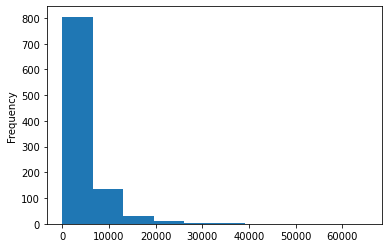

In [58]:
matrix_extended.groupby('user').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [60]:
matrix_extended.groupby('item').count()['rating'].describe()

count    929536.000000
mean          4.660914
std          10.819621
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         346.000000
Name: rating, dtype: float64

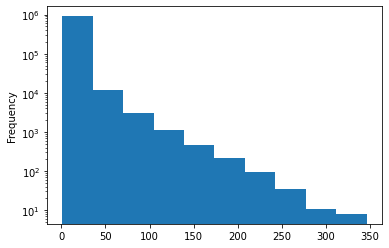

In [59]:
matrix_extended.groupby('item').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

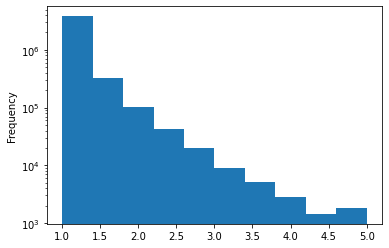

In [61]:
matrix_extended['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [71]:
items_app = matrix_extended.groupby('item').count()['rating']
items_app = items_app.loc[items_app > 3.99].index
matrix_sampled = matrix_extended.copy()
matrix_sampled = matrix_sampled.set_index('item')
matrix_sampled = matrix_sampled.loc[items_app]
matrix_sampled = matrix_sampled.reset_index()
matrix_sampled = matrix_sampled.sample(frac=1)

In [72]:
matrix_sampled.groupby('item').count()['rating'].describe()

count    246166.000000
mean         13.687402
std          18.169400
min           4.000000
25%           5.000000
50%           8.000000
75%          15.000000
max         346.000000
Name: rating, dtype: float64

### Sample Users

In [73]:
# no_users = 200
# users_list = matrix_extended.user.unique()
# users_sampled = np.random.choice(users_list, replace=False, size=no_users)
# matrix_sampled = matrix_extended.copy()
# matrix_sampled = matrix_sampled.set_index('user')
# matrix_sampled = matrix_sampled.loc[users_sampled]
# matrix_sampled = matrix_sampled.reset_index()
# matrix_sampled = matrix_sampled.sample(frac=1)
# matrix_sampled['item'] = matrix_sampled.apply(lambda row: row[1]+'-'+row[2], axis=1)

In [74]:
matrix_sampled.head()

,item,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
1904276,Neko Case-That Teenage Feeling,user_000474,Neko Case,That Teenage Feeling,1.000000,65049,0.459,0.672,0.0,-4.673,1.0,0.0265,0.810,0.000466,0.0630,0.184,98.309,162933.0,"['new americana', 'canadian indie', 'stomp and...",53,[5.33030975 8.4502195 1.4512068 ],5.330310,8.450220,1.451207
2619633,T-Pain-My Place,user_000869,T-Pain,My Place,1.000000,452256,0.754,0.258,6.0,-13.883,1.0,0.0680,0.199,0.000000,0.0762,0.538,121.950,219973.0,"['rap', 'dance pop', 'southern hip hop', 'pop'...",83,[4.7759564 7.6096121 3.8800874],4.775956,7.609612,3.880087
683591,Dashboard Confessional-Little Bombs,user_000610,Dashboard Confessional,Little Bombs,1.032086,290021,0.497,0.451,1.0,-6.407,1.0,0.0293,0.155,0.000000,0.1270,0.736,147.889,152453.0,"['neo mellow', 'pop punk', 'pop rock', 'emo']",62,[6.08791385 9.376354 0.68443023],6.087914,9.376354,0.684430
2874244,The Jeff Healey Band-See The Light,user_000016,The Jeff Healey Band,See The Light,1.000000,48500,0.413,0.971,7.0,-5.746,1.0,0.1250,0.111,0.000145,0.3320,0.294,111.938,266933.0,"['classic rock', 'electric blues', 'blues rock...",51,[4.528097 7.4739348 0.31085599],4.528097,7.473935,0.310856
1755774,Michael Jackson-The Lady In My Life,user_000753,Michael Jackson,The Lady In My Life,1.666667,27538,0.662,0.344,9.0,-13.930,0.0,0.0487,0.369,0.000109,0.0589,0.436,146.016,300107.0,"['soul', 'pop', 'r&b']",86,[4.87803435 7.56763685 3.7876339 ],4.878034,7.567637,3.787634


In [75]:
matrix_sampled['user_id'] = matrix_sampled['user'].astype('category').cat.codes
matrix_sampled['item_id'] = matrix_sampled['item'].astype('category').cat.codes

In [76]:
X = matrix_sampled[['user_id', 
              'item_id',
              'danceability',
              'energy',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness',
              'valence', 
              'tempo', 
              'popularity', 
              'emb_x', 
              'emb_y',
              'emb_z']]
y = matrix_sampled['rating']
groups = matrix_sampled['user_id']

In [77]:
# Change splitting to be by index using https://stackoverflow.com/questions/53490497/getting-validation-set-from-train-set-by-using-percentage-from-groupby-in-pand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups)

In [78]:
no_users, no_items, no_factors = matrix_sampled['user_id'].nunique(), matrix_sampled['item_id'].nunique(), 100

In [79]:
no_users

991

In [80]:
no_items

246166

### Models

In [81]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [82]:
model = create_shallow_model(no_factors, no_users, no_items)

In [83]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       99200       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       24616700    item_id[0][0]                    
______________________________________________________________________________________

In [87]:
def create_deep_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(16,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(8,name='fc4', activation='relu')(dropout_1)
    dense_2_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_2)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_2_output], name='deep_model')
    return model

In [88]:
model = create_deep_model(no_factors, no_users, no_items)

### Model training

In [ ]:
# Input-output data definition
X_train_arr = [X_train.user_id, X_train.item_id]

# Model creation
model = create_deep_model(no_factors, no_users, no_items)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError())

# Model training
model.fit(X_train_arr, y_train, epochs=10, batch_size=2048, shuffle=True)

Epoch 1/10
 418/1317 [========>.....................] - ETA: 1:39 - loss: 0.1418

### Prediction

In [ ]:
# Predictions in the training set
# X_train = [X_train.user_id, X_train.item_id]
y_train_pred = model.predict(X_train_arr, batch_size=2048)

In [ ]:
X_test.head()

In [ ]:
# Predictions in the test set
X_test_arr = [X_test.user_id, X_test.item_id]
y_test_pred = model.predict(X_test_arr, batch_size=2048)

### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

In [ ]:
def precision_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=5):
    precisions = []
    # For each user
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve already-seen items
        train_pids = train_ratings[train_ratings['user_id'] == user_id]['item_id'].values
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        # Sort the items and het the top k
        top_k = np.argsort(predictions)[:k]
        top_k_items = set(np.array(test_pids)[top_k])
        # Compute precision as per definition
        precisions.append(len(top_k_items & relevant_pids) / float(k))
    return precisions

In [ ]:
X_train_arr = np.array(X_train_arr)
X_test_arr = np.array(X_test_arr)

In [ ]:
train_ratings = pd.DataFrame({'user_id': X_train_arr[0, :], 'item_id':X_train_arr[1, :], 'rating': y_train})
test_ratings = pd.DataFrame({'user_id': X_test_arr[0, :], 'item_id':X_test_arr[1, :], 'rating': y_test})

In [ ]:
precisions = precision_at_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, k=10)

In [ ]:
np.mean(precisions), np.std(precisions)

In [ ]:
(test_ratings.groupby('user_id').count())['item_id'].mean()

In [268]:
np.array(test_pids)[top_k[:10]]

array([ 60493,   3390, 155070, 217176, 236222,  84621,  55342,  71947,
        61432, 109592], dtype=int32)

In [274]:
### EXERCISE CELL ###
def recall_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=100):
    recalls = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve already-seen items
        train_pids = train_ratings[train_ratings['user_id'] == user_id]['item_id'].values
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        # Sort the items and het the top k
        top_k = np.argsort(predictions)[:k]
        top_k_items = set(np.array(test_pids)[top_k])
        recalls.append(len(top_k_items & relevant_pids) / len(relevant_pids))
    return recalls

In [278]:
recalls = recall_at_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, k=10)

100%|██████████| 200/200 [00:12<00:00, 16.29it/s]


In [279]:
np.mean(recalls), np.std(recalls)

(0.022064475724596837, 0.055463911931586986)

In [ ]:
### EXERCISE CELL ###
def map_at_k(model, pred_func, train_ratings, test_ratings, no_users, no_items, k=10):
    pid_array = np.arange(no_items, dtype=np.int32)
    maps = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        train_pids = train_ratings[train_ratings['user_id'] == user_id]['item_id'].values
        test_pids = set(user_test_rating['item_id'].values)
        test_set = pd.DataFrame({'user_id': user_id, 'item_id': pid_array})
        test_set = [test_set.user_id, test_set.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        predictions = predictions.reshape(-1)
        predictions[train_pids] = - math.inf
        partial_maps = []
        top_k = list(np.argsort(-predictions)[:k])
        for rank, item_id in enumerate(top_k):
            if item_id in test_pids:
                partial_maps.append(len(set(top_k[:rank+1]) & test_pids) / float(rank+1))
        maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [ ]:
maps = map_at_k(model, predict_from_latent, train_ratings, test_ratings, no_users, no_items, k=10)

100%|██████████| 200/200 [01:07<00:00,  2.96it/s]


In [ ]:
np.mean(maps), np.std(maps)

(8.333333333333333e-05, 0.0011755613316388237)